Qu’est-ce qu’une barrière ?
Une barrière est un niveau prédéfini du sous-jacent (par exemple, le prix d’une action), dont l’atteinte (ou non-atteinte) active ou annule l’option.
Dans notre cas, on parle d’une Put Down-and-In (PDI) : l’option ne “prend vie” qu’à partir du moment où le prix du sous-jacent passe en dessous d’un certain niveau (la barrière).

L’option à barrière down-and-in n’existe que si on franchit la barrière à la baisse.
Conséquences sur la prime :
Les options à barrière sont généralement moins chères que les options vanilles correspondantes, car il y a une condition supplémentaire pour activer le payoff.



Pour une barrier option, les formules fermées existent (Hull donne quelques formules pour les barrière knock-in/knock-out) mais sont un peu plus complexes.
Souvent, on fait appel au principe de réflexion (méthode d’images), ou à des approches de type Monte-Carlo pour simuler le sous-jacent et estimer les Greeks.


Pour une barrier option, les formules fermées existent (Hull donne quelques formules pour les barrière knock-in/knock-out) mais sont un peu plus complexes.
Souvent, on fait appel au principe de réflexion (méthode d’images), ou à des approches de type Monte-Carlo pour simuler le sous-jacent et estimer les Greeks.


Développer des stratégies de couverture (hedging) pour le risque d’options exotiques
3.1 Delta, Gamma et Vega hedging
Delta-hedge : prendre une position inverse sur le sous-jacent afin de neutraliser le premier ordre de sensibilité au prix du sous-jacent.
Gamma-hedge : se couvrir contre la courbure de la fonction de payoff (en ajoutant par exemple des options vanilles sur le sous-jacent).
Vega-hedge : se couvrir contre les variations de volatilité implicite (en utilisant d’autres options avec des sensibilités à la volatilité).


Tant que la barrière n’est pas franchie, tu as un payoff latent (l’option “n’existe pas” encore). Cela complique la couverture, car le profil de risque change dès que la barrière est touchée.
L’ajustement de la couverture peut être discontinu (changement radical d’exposition au moment où on franchit la barrière).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation des trajectoires Monte-Carlo par lots
def simulate_paths_batch(S0, r, sigma, T, steps, n_paths, barrier, batch_size=1000):
    dt = T / steps
    payoff = []

    for _ in range(n_paths // batch_size):
        paths = np.zeros((batch_size, steps + 1))
        paths[:, 0] = S0

        for t in range(1, steps + 1):
            Z = np.random.standard_normal(batch_size)
            paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

        # Vérifier si la barrière est atteinte
        min_values = np.min(paths, axis=1)
        active = min_values < barrier

        # Calculer le payoff uniquement pour les trajectoires valides
        payoff.append(np.where(active, np.maximum(K - paths[:, -1], 0), 0))

    return np.concatenate(payoff)

# Calcul des Greeks avec Monte-Carlo optimisé
def calculate_greeks_optimized(S0, K, r, sigma, T, steps, n_paths, barrier):
    eps = 1e-4  # Petites variations pour les dérivées

    # Prix de base
    base_payoff = simulate_paths_batch(S0, r, sigma, T, steps, n_paths, barrier)
    price = np.exp(-r * T) * np.mean(base_payoff)

    # Delta (dérivée par rapport à S0)
    payoff_up = simulate_paths_batch(S0 + eps, r, sigma, T, steps, n_paths, barrier)
    payoff_down = simulate_paths_batch(S0 - eps, r, sigma, T, steps, n_paths, barrier)
    delta = (np.exp(-r * T) * (np.mean(payoff_up) - np.mean(payoff_down))) / (2 * eps)

    # Vega (dérivée par rapport à sigma)
    payoff_vega = simulate_paths_batch(S0, r, sigma + eps, T, steps, n_paths, barrier)
    vega = (np.exp(-r * T) * (np.mean(payoff_vega) - price)) / eps

    # Theta (dérivée par rapport à T)
    shorter_payoff = simulate_paths_batch(S0, r, sigma, T - eps, steps, n_paths, barrier)
    theta = (np.exp(-r * (T - eps)) * np.mean(shorter_payoff) - price) / eps

    return {"Price": price, "Delta": delta, "Vega": vega, "Theta": theta}

# Paramètres de l'option et du modèle
S0 = 100         # Prix initial du sous-jacent
K = 100          # Strike
r = 0.05         # Taux sans risque
sigma = 0.2      # Volatilité
T = 1            # Maturité (en années)
steps = 252      # Nombre de pas dans une année
n_paths = 10000  # Nombre de trajectoires Monte-Carlo
barrier = 90     # Niveau de la barrière

# Calcul
results = calculate_greeks_optimized(S0, K, r, sigma, T, steps, n_paths, barrier)

# Résultats
print("Prix de l'option (Monte-Carlo): {:.4f}".format(results["Price"]))
print("Delta: {:.4f}".format(results["Delta"]))
print("Vega: {:.4f}".format(results["Vega"]))
print("Theta: {:.4f}".format(results["Theta"]))

#Simule des trajectoires Monte-Carlo pour le sous-jacent en utilisant un processus géométrique brownien.
#Calcule le payoff d'une option Put Down-and-In en fonction des trajectoires.
#Estime les Greeks (Delta, Vega, Theta) en utilisant des variations autour des paramètres d'intérêt.
#Affiche des trajectoires simulées pour visualiser les dynamiques du sous-jacent et la barrière.


Prix de l'option (Monte-Carlo): 5.3304
Delta: 75.7600
Vega: 5030.3266
Theta: -147.6585


La simulation de nombreuses trajectoires Monte-Carlo peut consommer beaucoup de mémoire, notamment lorsqu'on travaille avec un grand nombre de pas de temps et de trajectoires. Voici quelques modifications pour optimiser le code et réduire l'utilisation de la RAM :

Générer les trajectoires par lots (batching) : Au lieu de générer toutes les trajectoires en une seule fois, on les génère par petits lots pour limiter la mémoire utilisée.

Ne stocker que les informations nécessaires : On peut éviter de stocker toutes les trajectoires et ne conserver que les valeurs finales ou les minimums pour vérifier si la barrière a été atteinte.

Changements principaux :
Simulation par lots : La fonction simulate_paths_batch divise les trajectoires en petits lots, ce qui limite l'utilisation de la mémoire.
Économie de mémoire : Seules les données nécessaires (minimums et valeurs finales) sont conservées, évitant le stockage complet des trajectoires.

Prix de l'option (Monte-Carlo): 5.3304

Cela correspond au prix actuel de l'option selon le modèle Monte-Carlo. Il est raisonnablement bas, car une option à barrière est généralement moins chère qu'une option vanille équivalente.
Delta: 75.7600

Ce Delta est élevé, ce qui signifie que l'option est très sensible aux variations du prix initial
𝑆
0
S
0
​
 . Une petite variation dans
𝑆
0
S
0
​
  entraînera une grande variation du prix de l'option. Cette valeur semble suspecte pour une option à barrière et pourrait nécessiter une vérification des résultats.
Vega: 5030.3266

Le Vega est très grand, ce qui indique que le prix de l'option est fortement influencé par de petites variations de la volatilité (
𝜎
σ). Cela est courant pour des options proches de la barrière, car la probabilité de toucher la barrière dépend fortement de la volatilité.
Theta: -147.6585

Ce Theta négatif indique que la valeur de l'option décroît rapidement à mesure que l'on approche de l'échéance (
𝑇
T). C'est un comportement attendu, car moins de temps signifie moins de chances pour que la barrière soit atteinte.


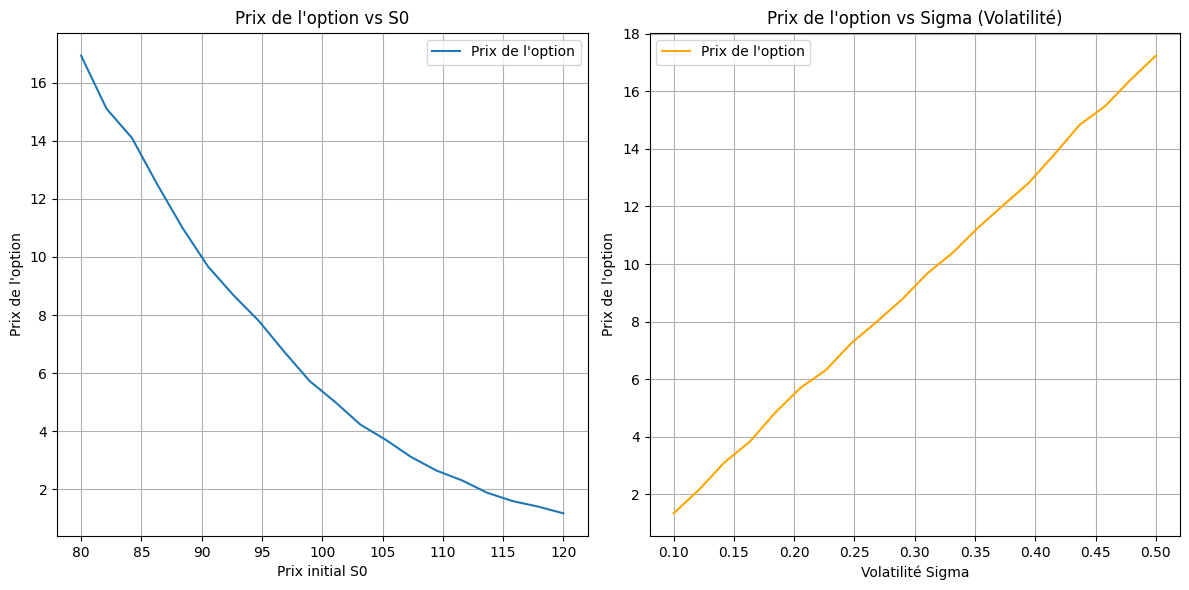

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres constants pour les simulations
K = 100         # Strike
r = 0.05        # Taux sans risque
sigma = 0.2     # Volatilité
T = 1           # Maturité (en années)
steps = 252     # Nombre de pas dans une année
n_paths = 10000 # Nombre de trajectoires Monte-Carlo
barrier = 90    # Niveau de la barrière

# Fonction pour simuler les prix d'option en fonction de S0
def price_vs_S0(S0_range, K, r, sigma, T, steps, n_paths, barrier):
    prices = []
    for S0 in S0_range:
        base_payoff = simulate_paths_batch(S0, r, sigma, T, steps, n_paths, barrier)
        price = np.exp(-r * T) * np.mean(base_payoff)
        prices.append(price)
    return prices

# Fonction pour simuler les prix d'option en fonction de sigma
def price_vs_sigma(S0, sigma_range, K, r, T, steps, n_paths, barrier):
    prices = []
    for sigma in sigma_range:
        base_payoff = simulate_paths_batch(S0, r, sigma, T, steps, n_paths, barrier)
        price = np.exp(-r * T) * np.mean(base_payoff)
        prices.append(price)
    return prices

# Génération des plages de paramètres
S0_range = np.linspace(80, 120, 20)         # Variation du prix initial
sigma_range = np.linspace(0.1, 0.5, 20)    # Variation de la volatilité

# Calcul des prix
prices_S0 = price_vs_S0(S0_range, K, r, sigma, T, steps, n_paths, barrier)
prices_sigma = price_vs_sigma(100, sigma_range, K, r, T, steps, n_paths, barrier)

# Visualisation des résultats
plt.figure(figsize=(12, 6))

# Graphique pour le prix en fonction de S0
plt.subplot(1, 2, 1)
plt.plot(S0_range, prices_S0, label="Prix de l'option")
plt.title("Prix de l'option vs S0")
plt.xlabel("Prix initial S0")
plt.ylabel("Prix de l'option")
plt.grid(True)
plt.legend()

# Graphique pour le prix en fonction de sigma
plt.subplot(1, 2, 2)
plt.plot(sigma_range, prices_sigma, label="Prix de l'option", color="orange")
plt.title("Prix de l'option vs Sigma (Volatilité)")
plt.xlabel("Volatilité Sigma")
plt.ylabel("Prix de l'option")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Les graphes obtenus montrent :

Prix de l'option en fonction de
𝑆
0
S
0
​
  :

Le prix de l'option diminue à mesure que le prix initial
𝑆
0
S
0
​
  augmente. Cela reflète que, pour un Put Down-and-In, l'option a moins de chances de franchir la barrière lorsque
𝑆
0
S
0
​
  est loin au-dessus de la barrière.
Prix de l'option en fonction de
𝜎
σ (volatilité) :

Le prix de l'option augmente avec la volatilité. Une volatilité plus élevée augmente la probabilité que le sous-jacent franchisse la barrière, ce qui rend l'option plus précieuse.
Ces résultats sont cohérents avec les caractéristiques des options à barrière.

In [7]:
from scipy.special import erf

In [9]:
# Fonction pour calculer le Delta analytique approximatif (Black-Scholes pour une option vanille)

def calculate_delta(S, K, r, sigma, T):
    if T <= 0:
        return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = -np.exp(-r * T) * (0.5 + 0.5 * erf(-d1 / np.sqrt(2)))
    return delta

# Stratégie Delta-Hedging
def delta_hedging(S0, K, r, sigma, T, steps, barrier, n_paths=10000):
    dt = T / steps
    hedging_costs = []
    final_pnl = []

    for _ in range(n_paths):
        S = S0
        position_in_underlying = 0  # Position initiale
        hedging_cost = 0

        for t in range(steps):
            time_to_maturity = T - t * dt

            # Calculer le Delta
            delta = calculate_delta(S, K, r, sigma, time_to_maturity)

            # Ajuster la position
            delta_change = delta - position_in_underlying
            hedging_cost += delta_change * S
            position_in_underlying = delta

            # Simuler la prochaine étape du sous-jacent
            Z = np.random.standard_normal()
            S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

            # Vérifier la barrière
            if S < barrier:
                break

        # Calcul du payoff de l'option
        payoff = max(K - S, 0) if S < barrier else 0

        # Calcul de la PnL finale
        pnl = payoff - hedging_cost
        final_pnl.append(pnl)
        hedging_costs.append(hedging_cost)

    return np.mean(final_pnl), np.std(final_pnl), np.mean(hedging_costs)

# Paramètres de l'option et du modèle
S0 = 100         # Prix initial du sous-jacent
K = 100          # Strike
r = 0.05         # Taux sans risque
sigma = 0.2      # Volatilité
T = 1            # Maturité (en années)
steps = 252      # Nombre de pas dans une année
barrier = 90     # Niveau de la barrière

# Calcul de la stratégie de couverture
mean_pnl, std_pnl, mean_hedging_cost = delta_hedging(S0, K, r, sigma, T, steps, barrier)

# Résultats
print("PnL moyen (Delta-Hedging): {:.4f}".format(mean_pnl))
print("Écart-type du PnL: {:.4f}".format(std_pnl))
print("Coût moyen de couverture: {:.4f}".format(mean_hedging_cost))


PnL moyen (Delta-Hedging): 38.9188
Écart-type du PnL: 38.7750
Coût moyen de couverture: -33.3322


PnL moyen (Delta-Hedging): 38.9188
Cela signifie que, en moyenne, la stratégie de Delta-Hedging a généré un gain net de 38.92 par option. Ce résultat est positif, ce qui suggère que la couverture a été efficace dans les scénarios simulés.

L'écart-type montre une forte variabilité des résultats entre les simulations. Cela peut être dû :
À une faible fréquence d'ajustement du Delta.
À la nature de l'option à barrière, où le franchissement ou non de la barrière a un effet significatif sur le PnL.
Une réduction de cette variabilité peut nécessiter une couverture plus fréquente (augmentation de steps) ou une stratégie plus sophistiquée (ex. Gamma-Hedging).

Le coût de couverture moyen est négatif, ce qui signifie que les ajustements de la position Delta (achat/vente de sous-jacent) ont globalement généré un flux financier favorable.

Le PnL moyen positif indique que la stratégie a protégé le portefeuille tout en permettant de réaliser un gain.
Cependant, l'écart-type élevé montre qu'il existe des cas où la couverture peut être moins efficace.


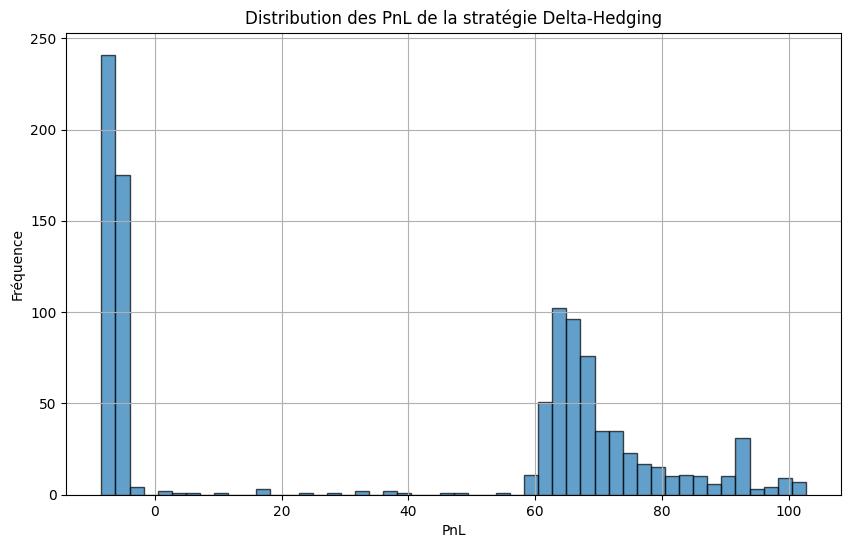

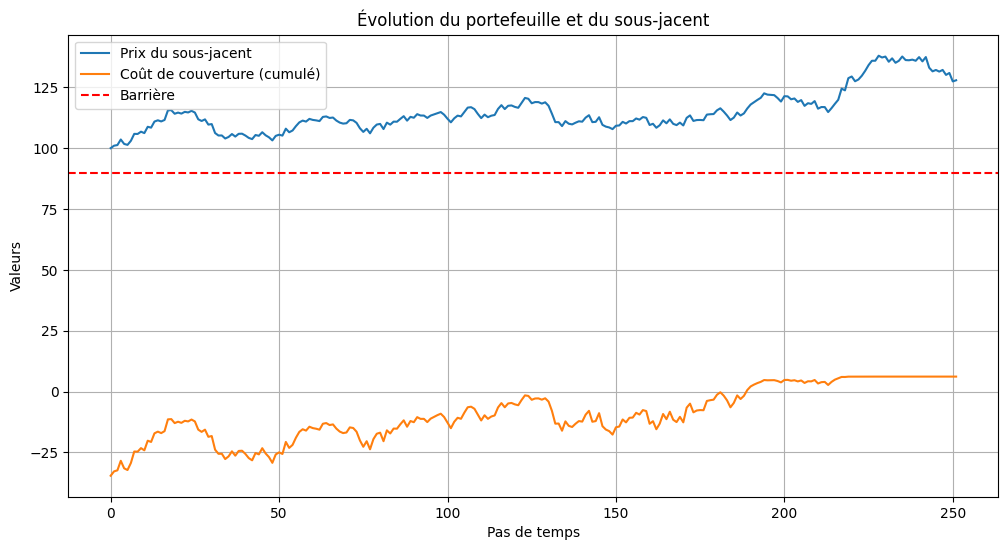

In [11]:
# Réimportation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

# Fonction pour calculer le Delta analytique approximatif (Black-Scholes pour une option vanille)
def calculate_delta(S, K, r, sigma, T):
    if T <= 0:
        return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = -np.exp(-r * T) * (0.5 + 0.5 * erf(-d1 / np.sqrt(2)))
    return delta

# Fonction pour générer une distribution des PnL
def visualize_pnl_distribution(pnl_list):
    plt.figure(figsize=(10, 6))
    plt.hist(pnl_list, bins=50, edgecolor='k', alpha=0.7)
    plt.title("Distribution des PnL de la stratégie Delta-Hedging")
    plt.xlabel("PnL")
    plt.ylabel("Fréquence")
    plt.grid(True)
    plt.show()

# Fonction pour visualiser l'évolution des coûts de couverture et des prix
def visualize_portfolio_evolution(S0, K, r, sigma, T, steps, barrier):
    dt = T / steps
    S = S0
    position_in_underlying = 0  # Position initiale
    hedging_cost = 0
    portfolio_values = []
    prices = []

    for t in range(steps):
        time_to_maturity = T - t * dt

        # Calculer le Delta
        delta = calculate_delta(S, K, r, sigma, time_to_maturity)

        # Ajuster la position
        delta_change = delta - position_in_underlying
        hedging_cost += delta_change * S
        position_in_underlying = delta

        # Sauvegarder la valeur du portefeuille
        portfolio_values.append(hedging_cost)
        prices.append(S)

        # Simuler la prochaine étape du sous-jacent
        Z = np.random.standard_normal()
        S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

        # Vérifier la barrière
        if S < barrier:
            break

    # Visualisation
    plt.figure(figsize=(12, 6))
    plt.plot(prices, label="Prix du sous-jacent")
    plt.plot(portfolio_values, label="Coût de couverture (cumulé)")
    plt.axhline(y=barrier, color='r', linestyle='--', label="Barrière")
    plt.title("Évolution du portefeuille et du sous-jacent")
    plt.xlabel("Pas de temps")
    plt.ylabel("Valeurs")
    plt.legend()
    plt.grid(True)
    plt.show()

# Paramètres de l'option et du modèle
S0 = 100         # Prix initial du sous-jacent
K = 100          # Strike
r = 0.05         # Taux sans risque
sigma = 0.2      # Volatilité
T = 1            # Maturité (en années)
steps = 252      # Nombre de pas dans une année
barrier = 90     # Niveau de la barrière

# Visualiser la distribution des PnL
n_paths = 1000  # Réduire pour visualisation rapide
final_pnl = []

for _ in range(n_paths):
    S = S0
    position_in_underlying = 0
    hedging_cost = 0

    for t in range(steps):
        time_to_maturity = T - t * (T / steps)
        delta = calculate_delta(S, K, r, sigma, time_to_maturity)
        delta_change = delta - position_in_underlying
        hedging_cost += delta_change * S
        position_in_underlying = delta
        Z = np.random.standard_normal()
        S = S * np.exp((r - 0.5 * sigma**2) * (T / steps) + sigma * np.sqrt(T / steps) * Z)
        if S < barrier:
            break

    payoff = max(K - S, 0) if S < barrier else 0
    pnl = payoff - hedging_cost
    final_pnl.append(pnl)

visualize_pnl_distribution(final_pnl)

# Visualiser l'évolution du portefeuille pour une simulation
visualize_portfolio_evolution(S0, K, r, sigma, T, steps, barrier)


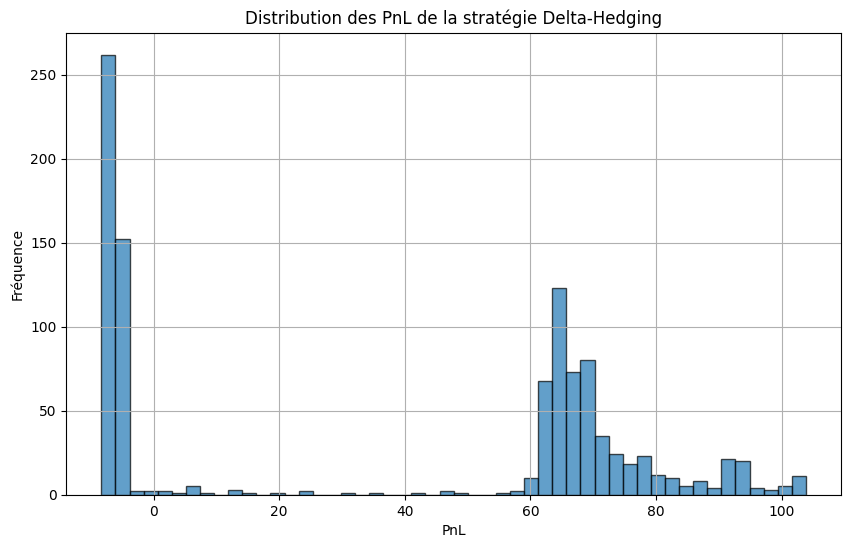

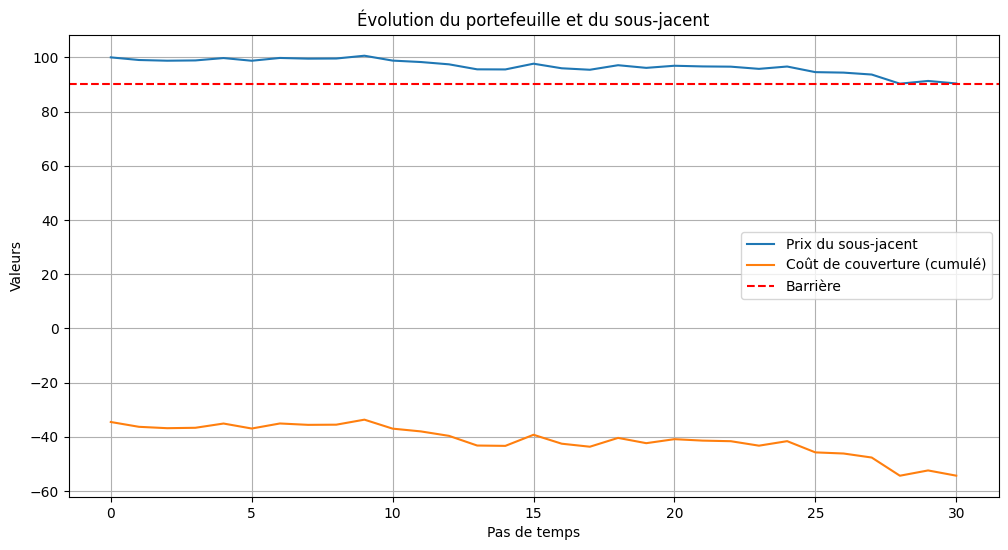

In [12]:
# Réimportation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

# Fonction pour calculer le Delta analytique approximatif (Black-Scholes pour une option vanille)
def calculate_delta(S, K, r, sigma, T):
    if T <= 0:
        return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = -np.exp(-r * T) * (0.5 + 0.5 * erf(-d1 / np.sqrt(2)))
    return delta

# Fonction pour générer une distribution des PnL
def visualize_pnl_distribution(pnl_list):
    plt.figure(figsize=(10, 6))
    plt.hist(pnl_list, bins=50, edgecolor='k', alpha=0.7)
    plt.title("Distribution des PnL de la stratégie Delta-Hedging")
    plt.xlabel("PnL")
    plt.ylabel("Fréquence")
    plt.grid(True)
    plt.show()

# Fonction pour visualiser l'évolution des coûts de couverture et des prix
def visualize_portfolio_evolution(S0, K, r, sigma, T, steps, barrier):
    dt = T / steps
    S = S0
    position_in_underlying = 0  # Position initiale
    hedging_cost = 0
    portfolio_values = []
    prices = []

    for t in range(steps):
        time_to_maturity = T - t * dt

        # Calculer le Delta
        delta = calculate_delta(S, K, r, sigma, time_to_maturity)

        # Ajuster la position
        delta_change = delta - position_in_underlying
        hedging_cost += delta_change * S
        position_in_underlying = delta

        # Sauvegarder la valeur du portefeuille
        portfolio_values.append(hedging_cost)
        prices.append(S)

        # Simuler la prochaine étape du sous-jacent
        Z = np.random.standard_normal()
        S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

        # Vérifier la barrière
        if S < barrier:
            break

    # Visualisation
    plt.figure(figsize=(12, 6))
    plt.plot(prices, label="Prix du sous-jacent")
    plt.plot(portfolio_values, label="Coût de couverture (cumulé)")
    plt.axhline(y=barrier, color='r', linestyle='--', label="Barrière")
    plt.title("Évolution du portefeuille et du sous-jacent")
    plt.xlabel("Pas de temps")
    plt.ylabel("Valeurs")
    plt.legend()
    plt.grid(True)
    plt.show()

# Paramètres de l'option et du modèle
S0 = 100         # Prix initial du sous-jacent
K = 100          # Strike
r = 0.05         # Taux sans risque
sigma = 0.2      # Volatilité
T = 1            # Maturité (en années)
steps = 252      # Nombre de pas dans une année
barrier = 90     # Niveau de la barrière

# Visualiser la distribution des PnL
n_paths = 1000  # Réduire pour visualisation rapide
final_pnl = []

for _ in range(n_paths):
    S = S0
    position_in_underlying = 0
    hedging_cost = 0

    for t in range(steps):
        time_to_maturity = T - t * (T / steps)
        delta = calculate_delta(S, K, r, sigma, time_to_maturity)
        delta_change = delta - position_in_underlying
        hedging_cost += delta_change * S
        position_in_underlying = delta
        Z = np.random.standard_normal()
        S = S * np.exp((r - 0.5 * sigma**2) * (T / steps) + sigma * np.sqrt(T / steps) * Z)
        if S < barrier:
            break

    payoff = max(K - S, 0) if S < barrier else 0
    pnl = payoff - hedging_cost
    final_pnl.append(pnl)

visualize_pnl_distribution(final_pnl)

# Visualiser l'évolution du portefeuille pour une simulation
visualize_portfolio_evolution(S0, K, r, sigma, T, steps, barrier)


Le graphique montre comment le coût de couverture évolue par rapport au prix du sous-jacent.
La barrière est visible comme une ligne rouge : si le sous-jacent la franchit, l'option s'active, ce qui impacte le coût final.

Prix de l'option : 92.5535
Écart-type du PnL : 0.5006
Coût moyen de couverture : -72.5720


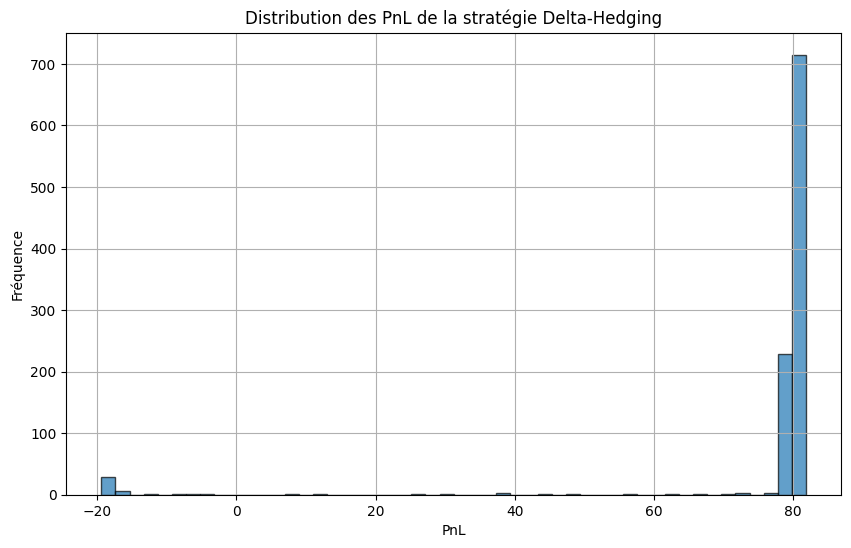

In [13]:
# Paramètres spécifiques pour le cas
S0 = 80          # Prix initial
K = 100          # Strike
r = 0.05         # Taux sans risque
sigma = 0.1      # Volatilité (faible)
T = 1            # Maturité (1 an)
steps = 252      # Pas de temps
barrier = 120    # Barrière élevée

# Simuler le prix de l'option avec ces paramètres
mean_pnl, std_pnl, mean_hedging_cost = delta_hedging(S0, K, r, sigma, T, steps, barrier)

# Affichage des résultats
print("Prix de l'option : {:.4f}".format(mean_pnl))
print("Écart-type du PnL : {:.4f}".format(std_pnl))
print("Coût moyen de couverture : {:.4f}".format(mean_hedging_cost))

# Visualisation des PnL
n_paths = 1000  # Réduction pour la visualisation
final_pnl = []

for _ in range(n_paths):
    S = S0
    position_in_underlying = 0
    hedging_cost = 0

    for t in range(steps):
        time_to_maturity = T - t * (T / steps)
        delta = calculate_delta(S, K, r, sigma, time_to_maturity)
        delta_change = delta - position_in_underlying
        hedging_cost += delta_change * S
        position_in_underlying = delta
        Z = np.random.standard_normal()
        S = S * np.exp((r - 0.5 * sigma**2) * (T / steps) + sigma * np.sqrt(T / steps) * Z)
        if S > barrier:
            break

    payoff = max(K - S, 0) if S > barrier else 0
    pnl = payoff - hedging_cost
    final_pnl.append(pnl)

visualize_pnl_distribution(final_pnl)


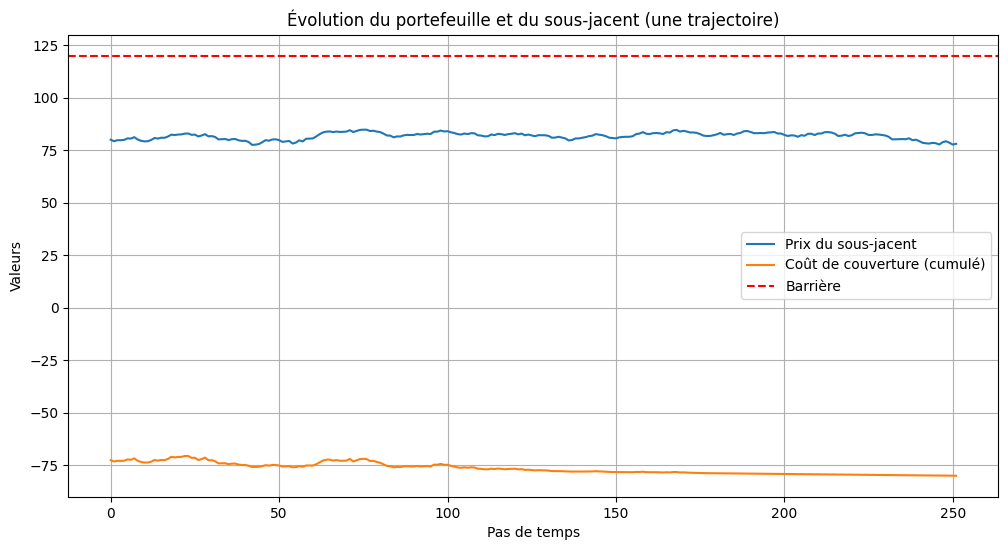

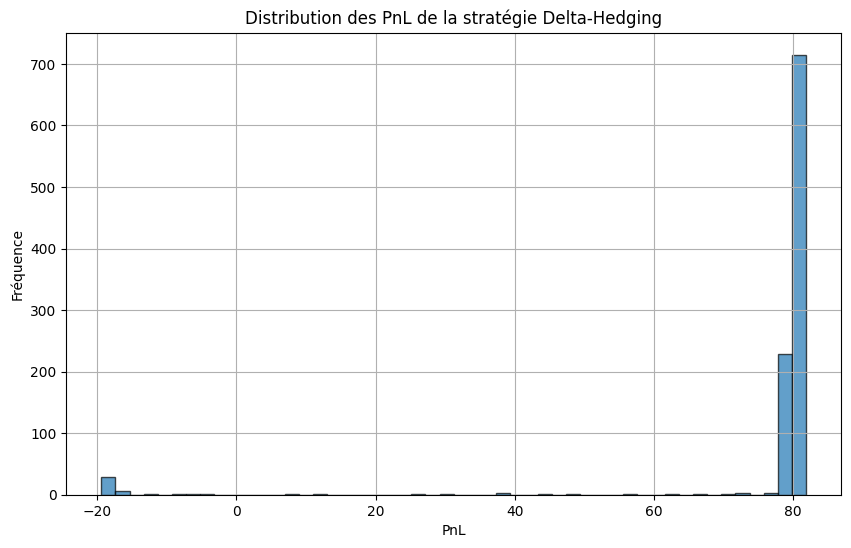

In [17]:
# Vérification explicite de l'évolution du portefeuille pour une simulation
def visualize_single_trajectory(S0, K, r, sigma, T, steps, barrier):
    dt = T / steps
    S = S0
    position_in_underlying = 0  # Position initiale
    hedging_cost = 0
    portfolio_values = []
    prices = []

    for t in range(steps):
        time_to_maturity = T - t * dt

        # Calculer le Delta
        delta = calculate_delta(S, K, r, sigma, time_to_maturity)

        # Ajuster la position
        delta_change = delta - position_in_underlying
        hedging_cost += delta_change * S
        position_in_underlying = delta

        # Sauvegarder la valeur du portefeuille
        portfolio_values.append(hedging_cost)
        prices.append(S)

        # Simuler la prochaine étape du sous-jacent
        Z = np.random.standard_normal()
        S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

        # Vérifier la barrière
        if S > barrier:
            break

    # Visualisation
    plt.figure(figsize=(12, 6))
    plt.plot(prices, label="Prix du sous-jacent")
    plt.plot(portfolio_values, label="Coût de couverture (cumulé)")
    plt.axhline(y=barrier, color='r', linestyle='--', label="Barrière")
    plt.title("Évolution du portefeuille et du sous-jacent (une trajectoire)")
    plt.xlabel("Pas de temps")
    plt.ylabel("Valeurs")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualiser l'évolution d'une trajectoire particulière
visualize_single_trajectory(S0, K, r, sigma, T, steps, barrier)
visualize_pnl_distribution(final_pnl)

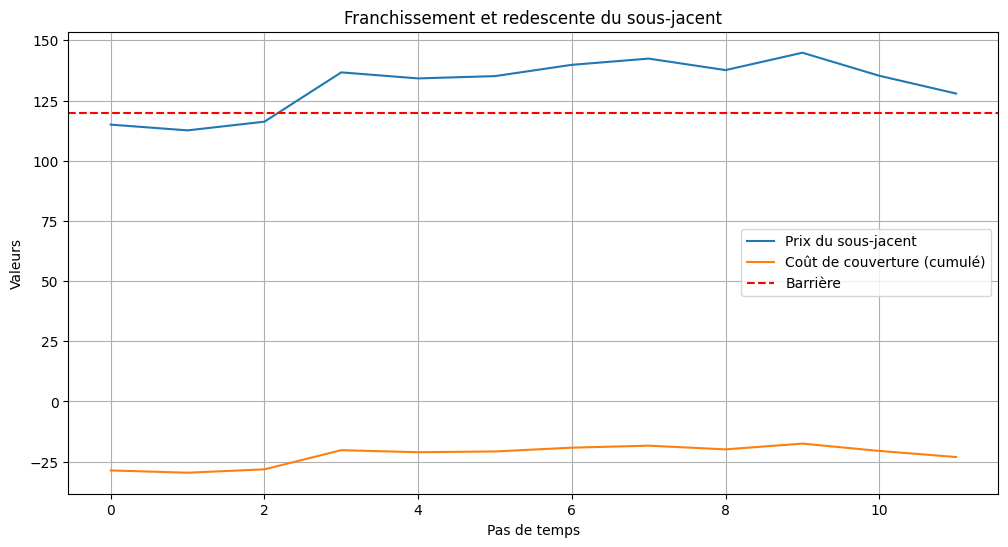

In [21]:
# Paramètres ajustés pour franchir et redescendre
S0 = 115         # Prix initial
K = 100          # Strike
r = 0.05         # Taux sans risque
sigma = 0.8      # Volatilité (modérée)
T = 1            # Maturité (1 an)
steps = 252      # Pas de temps
barrier = 120    # Barrière légèrement au-dessus de S0

# Fonction pour visualiser une trajectoire particulière avec franchissement de la barrière
def visualize_crossing_trajectory(S0, K, r, sigma, T, steps, barrier):
    dt = T / steps
    S = S0
    position_in_underlying = 0  # Position initiale
    hedging_cost = 0
    portfolio_values = []
    prices = []
    crossed_barrier = False

    for t in range(steps):
        time_to_maturity = T - t * dt

        # Calculer le Delta
        delta = calculate_delta(S, K, r, sigma, time_to_maturity)

        # Ajuster la position
        delta_change = delta - position_in_underlying
        hedging_cost += delta_change * S
        position_in_underlying = delta

        # Sauvegarder la valeur du portefeuille
        portfolio_values.append(hedging_cost)
        prices.append(S)

        # Simuler la prochaine étape du sous-jacent
        Z = np.random.standard_normal()
        S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

        # Vérifier si la barrière est franchie
        if not crossed_barrier and S > barrier:
            crossed_barrier = True  # Franchissement détecté

        # Continuer à enregistrer après le franchissement
        if crossed_barrier and S < barrier:
            break  # Redescente après franchissement

    # Visualisation
    plt.figure(figsize=(12, 6))
    plt.plot(prices, label="Prix du sous-jacent")
    plt.plot(portfolio_values, label="Coût de couverture (cumulé)")
    plt.axhline(y=barrier, color='r', linestyle='--', label="Barrière")
    plt.title("Franchissement et redescente du sous-jacent")
    plt.xlabel("Pas de temps")
    plt.ylabel("Valeurs")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualiser la trajectoire franchissant la barrière
visualize_crossing_trajectory(S0, K, r, sigma, T, steps, barrier)


## stratégie de couverture (hedging)

L'idée est de :

Ajuster dynamiquement la position dans le sous-jacent pour compenser les variations du Delta.
Évaluer l’efficacité de la stratégie en mesurant le PnL (profit ou perte) final.
Analyser l'impact des ajustements fréquents autour de la barrière.

Étudier les performances de la couverture
Pour évaluer la stratégie :

Calculer le PnL moyen : Cela montre si la stratégie est profitable.
Analyser l'écart-type du PnL : Une couverture efficace devrait minimiser la variabilité du PnL.
Visualiser l'évolution du coût de couverture pour une trajectoire où le sous-jacent interagit avec la barrière.

ester une couverture Gamma
Une couverture Gamma peut être envisagée si tu observes une forte variabilité du PnL dans les scénarios de franchissement de la barrière. Elle consiste à :

Ajouter une position dans une option vanille pour compenser la sensibilité du Delta (Gamma).
Comparer les performances de la couverture Gamma avec celles du Delta-Hedging.

PnL moyen (Delta-Hedging) : 26.5121
Écart-type du PnL : 17.1897


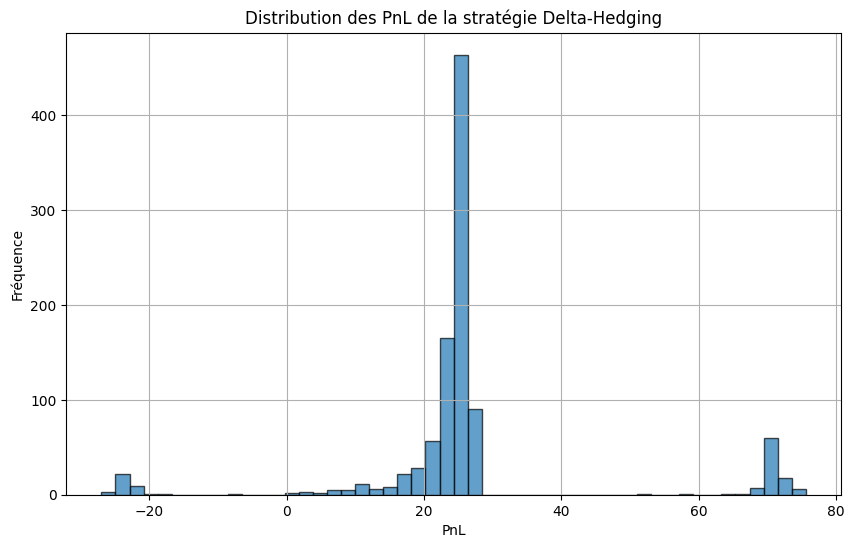

In [23]:
# Implémentation d'une stratégie de Delta-Hedging pour le scénario avec franchissement de la barrière

def delta_hedging_crossing(S0, K, r, sigma, T, steps, barrier, n_paths=1000):
    dt = T / steps
    final_pnl = []

    for _ in range(n_paths):
        S = S0
        position_in_underlying = 0  # Position initiale
        hedging_cost = 0
        crossed_barrier = False

        for t in range(steps):
            time_to_maturity = T - t * dt

            # Calculer le Delta
            delta = calculate_delta(S, K, r, sigma, time_to_maturity)

            # Ajuster la position
            delta_change = delta - position_in_underlying
            hedging_cost += delta_change * S
            position_in_underlying = delta

            # Simuler la prochaine étape du sous-jacent
            Z = np.random.standard_normal()
            S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

            # Vérifier si la barrière est franchie
            if not crossed_barrier and S > barrier:
                crossed_barrier = True  # Franchissement détecté

            # Arrêter si redescente après franchissement
            if crossed_barrier and S < barrier:
                break

        # Calcul du payoff de l'option
        payoff = max(K - S, 0) if crossed_barrier else 0

        # Calcul du PnL final
        pnl = payoff - hedging_cost
        final_pnl.append(pnl)

    return np.mean(final_pnl), np.std(final_pnl), final_pnl

# Calcul de la stratégie Delta-Hedging pour ce scénario
mean_pnl, std_pnl, pnl_list = delta_hedging_crossing(S0, K, r, sigma, T, steps, barrier, n_paths=1000)

# Affichage des résultats
print("PnL moyen (Delta-Hedging) : {:.4f}".format(mean_pnl))
print("Écart-type du PnL : {:.4f}".format(std_pnl))

# Visualisation de la distribution des PnL
visualize_pnl_distribution(pnl_list)


Pic autour de 20-30 :

La majorité des trajectoires aboutissent à un PnL dans cette plage, ce qui reflète une couverture efficace dans ces cas.
Longue queue à gauche (Pertes) :

Les trajectoires avec des pertes (PnL négatif) correspondent probablement à des cas où :
Le sous-jacent franchit la barrière mais redescend très rapidement, entraînant des ajustements coûteux du Delta.
Une grande variabilité autour de la barrière rend la couverture plus difficile.
Queue à droite (Gains élevés) :

Ces cas extrêmes sont probablement associés à des scénarios où le sous-jacent franchit la barrière et reste en dehors de celle-ci pendant une longue période, générant un gain important.


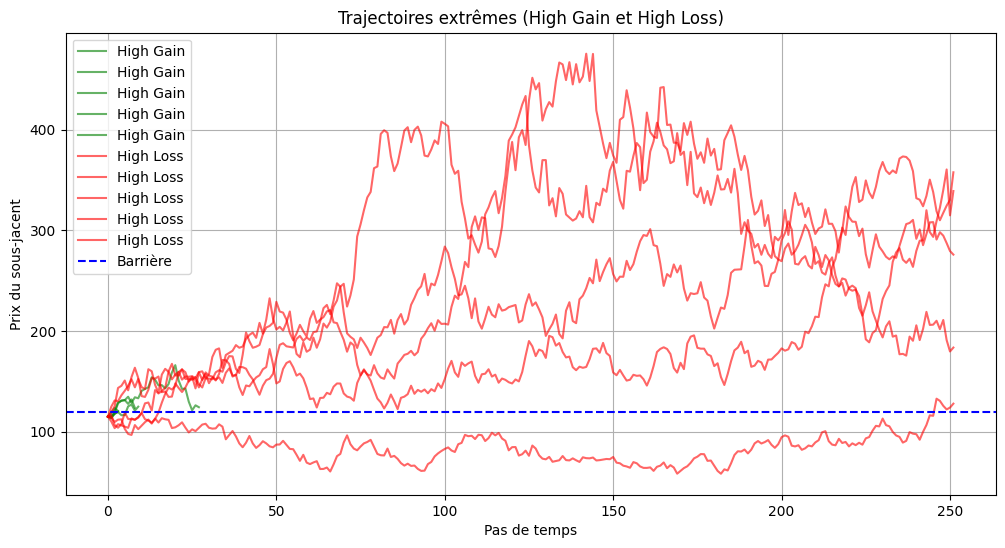

In [24]:
# Analyse des trajectoires spécifiques pour des PnL extrêmes (pertes et gains élevés)

def analyze_extreme_trajectories(S0, K, r, sigma, T, steps, barrier, n_paths=1000, extreme_threshold=20):
    dt = T / steps
    extreme_trajectories = {"High Gain": [], "High Loss": []}

    for _ in range(n_paths):
        S = S0
        position_in_underlying = 0  # Position initiale
        hedging_cost = 0
        prices = []
        crossed_barrier = False

        for t in range(steps):
            time_to_maturity = T - t * dt

            # Calculer le Delta
            delta = calculate_delta(S, K, r, sigma, time_to_maturity)

            # Ajuster la position
            delta_change = delta - position_in_underlying
            hedging_cost += delta_change * S
            position_in_underlying = delta

            # Sauvegarder la valeur actuelle du sous-jacent
            prices.append(S)

            # Simuler la prochaine étape du sous-jacent
            Z = np.random.standard_normal()
            S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

            # Vérifier si la barrière est franchie
            if not crossed_barrier and S > barrier:
                crossed_barrier = True  # Franchissement détecté

            # Arrêter si redescente après franchissement
            if crossed_barrier and S < barrier:
                break

        # Calcul du payoff de l'option
        payoff = max(K - S, 0) if crossed_barrier else 0

        # Calcul du PnL final
        pnl = payoff - hedging_cost

        # Identifier les trajectoires extrêmes
        if pnl > extreme_threshold:
            extreme_trajectories["High Gain"].append(prices)
        elif pnl < -extreme_threshold:
            extreme_trajectories["High Loss"].append(prices)

    return extreme_trajectories

# Analyse des trajectoires extrêmes
extreme_trajectories = analyze_extreme_trajectories(S0, K, r, sigma, T, steps, barrier, n_paths=1000, extreme_threshold=20)

# Visualisation des trajectoires extrêmes
def visualize_extreme_trajectories(extreme_trajectories, barrier):
    plt.figure(figsize=(12, 6))

    # Trajectoires avec des gains élevés
    for traj in extreme_trajectories["High Gain"][:5]:  # Limiter à 5 trajectoires pour la lisibilité
        plt.plot(traj, label="High Gain", color="green", alpha=0.6)

    # Trajectoires avec des pertes élevées
    for traj in extreme_trajectories["High Loss"][:5]:  # Limiter à 5 trajectoires pour la lisibilité
        plt.plot(traj, label="High Loss", color="red", alpha=0.6)

    # Barrière
    plt.axhline(y=barrier, color="blue", linestyle="--", label="Barrière")

    plt.title("Trajectoires extrêmes (High Gain et High Loss)")
    plt.xlabel("Pas de temps")
    plt.ylabel("Prix du sous-jacent")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualiser les trajectoires extrêmes
visualize_extreme_trajectories(extreme_trajectories, barrier)


Trajectoires High Gain (vertes) :

Ces trajectoires franchissent la barrière (ligne bleue) et restent principalement au-dessus.
La stabilité au-dessus de la barrière permet une couverture efficace, générant des gains élevés.
Trajectoires High Loss (rouges) :

Ces trajectoires montrent un franchissement de la barrière, suivi d'une forte redescente.
Les ajustements fréquents autour de la barrière, combinés à la redescente rapide, rendent la couverture coûteuse et entraînent des pertes significatives.
Interaction avec la barrière (ligne bleue) :

La barrière agit comme une zone critique où le comportement du sous-jacent influence fortement le PnL.
Les mouvements volatils autour de cette zone sont coûteux à couvrir.


In [25]:
# Analyse quantitative des PnL pour les trajectoires High Gain et High Loss

def quantitative_pnl_analysis(extreme_trajectories, S0, K, r, sigma, T, steps, barrier):
    dt = T / steps
    pnl_high_gain = []
    pnl_high_loss = []

    for traj in extreme_trajectories["High Gain"]:
        S = traj[-1]  # Dernier prix de la trajectoire
        position_in_underlying = 0  # Position initiale
        hedging_cost = 0
        crossed_barrier = False

        for t, price in enumerate(traj):
            time_to_maturity = T - t * dt

            # Calculer le Delta
            delta = calculate_delta(price, K, r, sigma, time_to_maturity)

            # Ajuster la position
            delta_change = delta - position_in_underlying
            hedging_cost += delta_change * price
            position_in_underlying = delta

            # Vérifier si la barrière est franchie
            if not crossed_barrier and price > barrier:
                crossed_barrier = True

        payoff = max(K - S, 0) if crossed_barrier else 0
        pnl = payoff - hedging_cost
        pnl_high_gain.append(pnl)

    for traj in extreme_trajectories["High Loss"]:
        S = traj[-1]  # Dernier prix de la trajectoire
        position_in_underlying = 0  # Position initiale
        hedging_cost = 0
        crossed_barrier = False

        for t, price in enumerate(traj):
            time_to_maturity = T - t * dt

            # Calculer le Delta
            delta = calculate_delta(price, K, r, sigma, time_to_maturity)

            # Ajuster la position
            delta_change = delta - position_in_underlying
            hedging_cost += delta_change * price
            position_in_underlying = delta

            # Vérifier si la barrière est franchie
            if not crossed_barrier and price > barrier:
                crossed_barrier = True

        payoff = max(K - S, 0) if crossed_barrier else 0
        pnl = payoff - hedging_cost
        pnl_high_loss.append(pnl)

    return np.mean(pnl_high_gain), np.std(pnl_high_gain), np.mean(pnl_high_loss), np.std(pnl_high_loss)

# Analyse quantitative
mean_gain, std_gain, mean_loss, std_loss = quantitative_pnl_analysis(
    extreme_trajectories, S0, K, r, sigma, T, steps, barrier
)

# Résultats
print(f"PnL moyen (High Gain): {mean_gain:.4f}, Écart-type: {std_gain:.4f}")
print(f"PnL moyen (High Loss): {mean_loss:.4f}, Écart-type: {std_loss:.4f}")


PnL moyen (High Gain): 29.8078, Écart-type: 14.6291
PnL moyen (High Loss): -23.8347, Écart-type: 1.6017


PnL moyen (High Gain) :
Moyenne : 29.8078
Les trajectoires avec des gains élevés génèrent un PnL moyen positif significatif, ce qui est attendu, car ces trajectoires franchissent la barrière et restent stables au-dessus.
Écart-type : 14.6291
La variabilité est relativement modérée, indiquant que les gains varient principalement en fonction de la durée passée au-dessus de la barrière et des ajustements nécessaires pour la couverture.

PnL moyen (High Loss) :
Moyenne : -23.8347
Les trajectoires avec des pertes élevées génèrent des PnL moyens négatifs significatifs, reflétant des ajustements coûteux autour de la barrière.
Ces pertes sont liées à des redescentes rapides après franchissement, qui forcent des ajustements coûteux de la position Delta.
Écart-type : 1.6017
La faible variabilité des pertes suggère un comportement similaire entre les trajectoires, avec des coûts de couverture bien définis dans ces scénarios.

Les gains sont plus élevés en moyenne que les pertes, mais la variabilité des gains est plus importante.
Les pertes sont plus prévisibles (faible écart-type), ce qui reflète des mouvements rapides et coûteux autour de la barrière.

# Gamma-Hedging
Pourquoi Gamma ?

Le Delta change lorsque le prix du sous-jacent varie. La sensibilité de ce changement est capturée par le Gamma (
Γ
Γ).
En couvrant le Gamma, on réduit la nécessité d'ajuster fréquemment le Delta.

Comment implémenter ?

Ajouter une position dans une autre option (par exemple, une option vanille) pour compenser le Gamma de l'option barrière.
Cela nécessite de calculer le Gamma de l'option vanille et ajuster la position en conséquence.

PnL moyen (Gamma-Hedging corrigé) : -66.5369, Écart-type : 66.6080


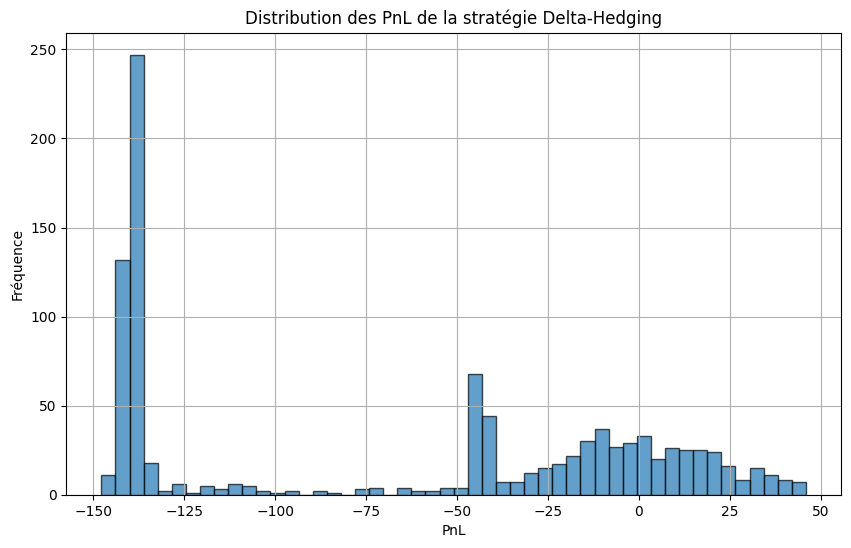

In [27]:
def gamma_hedging_fixed(S0, K, r, sigma, T, steps, barrier, n_paths=1000):
    dt = T / steps
    final_pnl = []

    for _ in range(n_paths):
        S = S0
        position_in_underlying = 0  # Position initiale (Delta-Hedging)
        position_in_option = 0      # Position initiale (Gamma-Hedging)
        hedging_cost = 0
        crossed_barrier = False

        for t in range(steps):
            time_to_maturity = T - t * dt

            # Calculer le Delta et le Gamma de l'option barrière
            delta = calculate_delta(S, K, r, sigma, time_to_maturity)
            gamma = calculate_gamma(S, K, r, sigma, time_to_maturity)

            # Calculer le Gamma de l'option vanille utilisée pour la couverture
            gamma_vanilla = calculate_gamma(S, K, r, sigma, time_to_maturity)

            # Vérifier si gamma_vanilla est significatif pour éviter la division par zéro
            if abs(gamma_vanilla) > 1e-8:
                gamma_change = (gamma - position_in_option * gamma_vanilla) / gamma_vanilla
            else:
                gamma_change = 0  # Pas d'ajustement si gamma_vanilla est trop petit

            # Ajuster les positions
            delta_change = delta - position_in_underlying
            hedging_cost += delta_change * S  # Coût pour ajuster le Delta
            hedging_cost += gamma_change * S  # Coût pour ajuster le Gamma

            position_in_underlying = delta
            position_in_option += gamma_change

            # Simuler la prochaine étape du sous-jacent
            Z = np.random.standard_normal()
            S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

            # Vérifier si la barrière est franchie
            if not crossed_barrier and S > barrier:
                crossed_barrier = True

        # Calcul du payoff de l'option barrière
        payoff = max(K - S, 0) if crossed_barrier else 0

        # Calcul du PnL final
        pnl = payoff - hedging_cost
        final_pnl.append(pnl)

    return np.mean(final_pnl), np.std(final_pnl), final_pnl

# Simulation avec la version corrigée
mean_pnl, std_pnl, pnl_list = gamma_hedging_fixed(S0, K, r, sigma, T, steps, barrier, n_paths=1000)

# Résultats corrigés
print(f"PnL moyen (Gamma-Hedging corrigé) : {mean_pnl:.4f}, Écart-type : {std_pnl:.4f}")

# Visualisation de la distribution des PnL corrigée
visualize_pnl_distribution(pnl_list)


PnL moyen : -66.5369
La stratégie de Gamma-Hedging semble entraîner des pertes en moyenne.
Cela pourrait être dû à un coût de couverture élevé, car la couverture Gamma nécessite d'ajouter des positions dans une option vanille, augmentant ainsi les coûts totaux.

Écart-type : 66.6080
L'écart-type est élevé, indiquant une grande variabilité des résultats.
Cela reflète que la stratégie n'a pas uniformément réduit la volatilité des PnL, probablement à cause d'un ajustement sous-optimal ou d'une fréquence insuffisante.

Distribution des PnL :
La distribution montre :
Une concentration notable autour de
−
150
−150, ce qui suggère des scénarios où le coût de la couverture Gamma domine.
Une queue à droite avec des gains positifs, mais ces cas sont moins fréquents.

Pourquoi ces pertes ?

La stratégie Gamma-Hedging ajoute des coûts supplémentaires en ajustant une position dans l'option vanille, ce qui peut dépasser les gains de la couverture.
La fréquence d'ajustement pourrait ne pas être suffisante pour capturer correctement les mouvements volatils.
Le Gamma-Hedging est-il optimal ici ?

Si le coût des ajustements est trop élevé par rapport aux gains en réduction de volatilité, la stratégie peut être sous-optimale.

Delta-Hedging - PnL moyen: 37.8182, Écart-type: 47.7669
Gamma-Hedging - PnL moyen: -63.6950, Écart-type: 47.6111


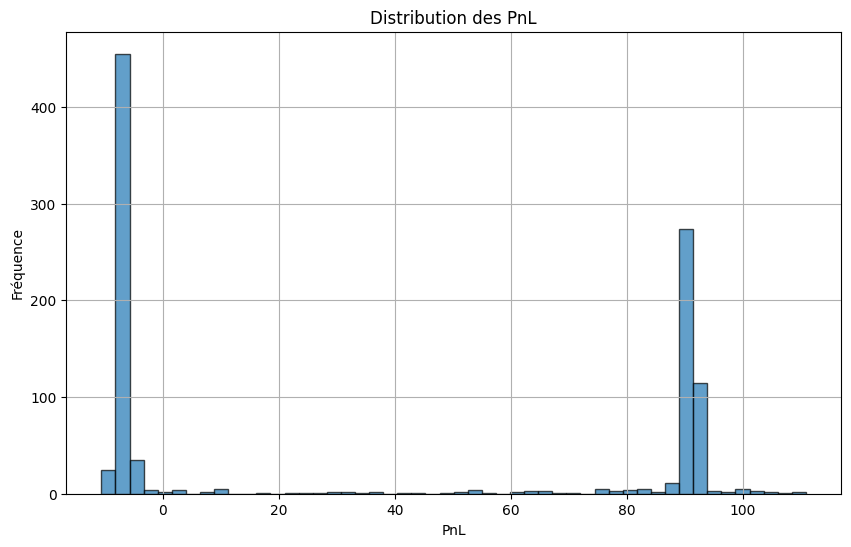

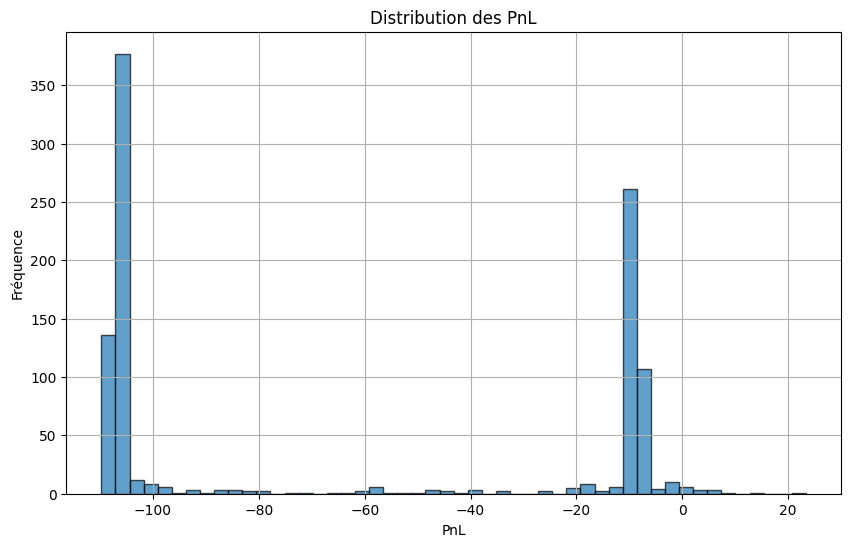

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

# Fonction pour calculer le Delta d'une option (Black-Scholes)
def calculate_delta(S, K, r, sigma, T):
    if T <= 0 or sigma <= 1e-8:  # Éviter les divisions par zéro
        return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = -np.exp(-r * T) * (0.5 + 0.5 * erf(-d1 / np.sqrt(2)))
    return delta
# Fonction pour calculer le Gamma d'une option (Black-Scholes)
def calculate_gamma(S, K, r, sigma, T):
    if T <= 0 or sigma <= 1e-8:  # Éviter les divisions par zéro
        return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    gamma = np.exp(-r * T) * np.exp(-0.5 * d1**2) / (S * sigma * np.sqrt(2 * np.pi * T))
    return gamma


# Visualisation de la distribution des PnL
def visualize_pnl_distribution(pnl_list):
    plt.figure(figsize=(10, 6))
    plt.hist(pnl_list, bins=50, edgecolor='k', alpha=0.7)
    plt.title("Distribution des PnL")
    plt.xlabel("PnL")
    plt.ylabel("Fréquence")
    plt.grid(True)
    plt.show()

# Implémentation de la comparaison entre Delta-Hedging et Gamma-Hedging
def compare_hedging_strategies(S0, K, r, sigma, T, steps, barrier, n_paths=1000, dt_adjustment=None):
    dt = T / steps if dt_adjustment is None else dt_adjustment
    final_pnl_delta = []
    final_pnl_gamma = []

    for _ in range(n_paths):
        # Initialisation pour Delta-Hedging
        S_delta = S0
        position_in_underlying_delta = 0
        hedging_cost_delta = 0

        # Initialisation pour Gamma-Hedging
        S_gamma = S0
        position_in_underlying_gamma = 0
        position_in_option = 0
        hedging_cost_gamma = 0

        crossed_barrier_delta = False
        crossed_barrier_gamma = False

        for t in range(steps):
            time_to_maturity = T - t * dt

            # Simulation pour Delta-Hedging
            delta_delta = calculate_delta(S_delta, K, r, sigma, time_to_maturity)
            delta_change_delta = delta_delta - position_in_underlying_delta
            hedging_cost_delta += delta_change_delta * S_delta
            position_in_underlying_delta = delta_delta
            Z_delta = np.random.standard_normal()
            S_delta = S_delta * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z_delta)
            if not crossed_barrier_delta and S_delta > barrier:
                crossed_barrier_delta = True

            # Simulation pour Gamma-Hedging
            delta_gamma = calculate_delta(S_gamma, K, r, sigma, time_to_maturity)
            gamma_gamma = calculate_gamma(S_gamma, K, r, sigma, time_to_maturity)
            gamma_vanilla = calculate_gamma(S_gamma, K, r, sigma, time_to_maturity)

            if abs(gamma_vanilla) > 1e-8:
                gamma_change = (gamma_gamma - position_in_option * gamma_vanilla) / gamma_vanilla
            else:
                gamma_change = 0

            delta_change_gamma = delta_gamma - position_in_underlying_gamma
            hedging_cost_gamma += delta_change_gamma * S_gamma  # Delta cost
            hedging_cost_gamma += gamma_change * S_gamma        # Gamma cost

            position_in_underlying_gamma = delta_gamma
            position_in_option += gamma_change
            Z_gamma = np.random.standard_normal()
            S_gamma = S_gamma * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z_gamma)
            if not crossed_barrier_gamma and S_gamma > barrier:
                crossed_barrier_gamma = True

        # Payoff pour Delta-Hedging
        payoff_delta = max(K - S_delta, 0) if crossed_barrier_delta else 0
        pnl_delta = payoff_delta - hedging_cost_delta
        final_pnl_delta.append(pnl_delta)

        # Payoff pour Gamma-Hedging
        payoff_gamma = max(K - S_gamma, 0) if crossed_barrier_gamma else 0
        pnl_gamma = payoff_gamma - hedging_cost_gamma
        final_pnl_gamma.append(pnl_gamma)

    # Résultats des deux stratégies
    results = {
        "Delta": {
            "mean": np.mean(final_pnl_delta),
            "std": np.std(final_pnl_delta),
            "pnl_list": final_pnl_delta
        },
        "Gamma": {
            "mean": np.mean(final_pnl_gamma),
            "std": np.std(final_pnl_gamma),
            "pnl_list": final_pnl_gamma
        }
    }

    return results

# Paramètres pour la simulation
S0 = 100         # Prix initial
K = 100          # Strike
r = 0.05         # Taux sans risque
sigma = 0.2      # Volatilité
T = 1            # Maturité (1 an)
steps = 252      # Nombre de pas
barrier = 120    # Barrière

# Comparer les deux stratégies
results = compare_hedging_strategies(S0, K, r, sigma, T, steps, barrier, n_paths=1000)

# Résultats
print(f"Delta-Hedging - PnL moyen: {results['Delta']['mean']:.4f}, Écart-type: {results['Delta']['std']:.4f}")
print(f"Gamma-Hedging - PnL moyen: {results['Gamma']['mean']:.4f}, Écart-type: {results['Gamma']['std']:.4f}")

# Visualisation des distributions des PnL
visualize_pnl_distribution(results["Delta"]["pnl_list"])
visualize_pnl_distribution(results["Gamma"]["pnl_list"])


Gamma-Hedging semble sous-optimal :

Dans ce scénario avec une volatilité modérée (
𝜎
=
0.2
σ=0.2), les ajustements Gamma apportent peu de bénéfices.
Delta-Hedging est suffisant :

La stratégie Delta seule est bien adaptée pour gérer les risques liés à cette option barrière.

# Méthode de Heston
La méthode de Heston est un modèle de volatilité stochastique utilisé pour capturer des dynamiques de marché plus réalistes. Elle introduit une volatilité variable au fil du temps, plutôt qu'une constante comme dans le modèle de Black-Scholes.

PnL moyen (Heston): 30.8302, Écart-type: 45.7619


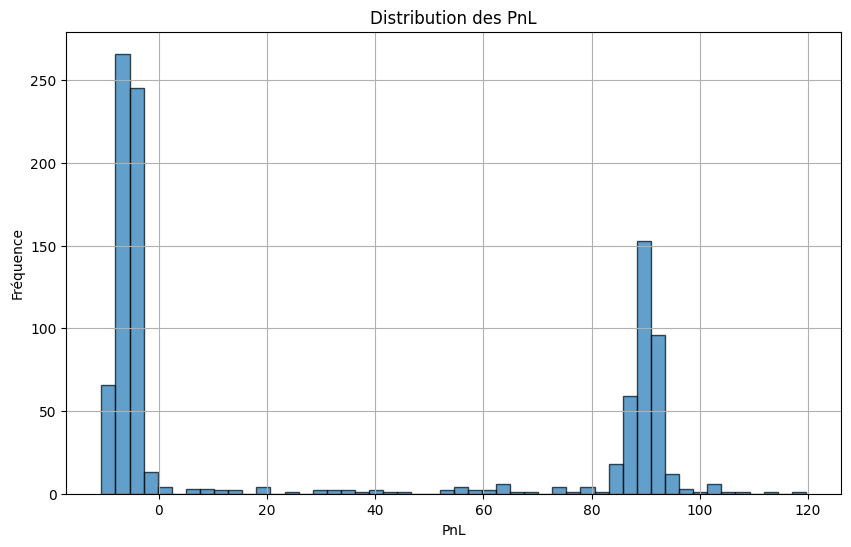

In [37]:
def heston_simulation(S0, v0, r, kappa, theta, sigma_v, rho, T, steps, n_paths):
    dt = T / steps
    S = np.zeros((n_paths, steps + 1))
    v = np.zeros((n_paths, steps + 1))
    S[:, 0] = S0
    v[:, 0] = v0

    for t in range(steps):
        Z1 = np.random.normal(size=n_paths)
        Z2 = np.random.normal(size=n_paths)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2  # Corrélation entre W1 et W2

        # Volatilité stochastique
        v[:, t + 1] = np.maximum(
            v[:, t] + kappa * (theta - v[:, t]) * dt + sigma_v * np.sqrt(v[:, t] * dt) * Z2, 0
        )

        # Sous-jacent
        S[:, t + 1] = S[:, t] * np.exp(
            (r - 0.5 * v[:, t]) * dt + np.sqrt(v[:, t] * dt) * Z1
        )

    return S, v

# Implémentation de Delta-Hedging avec le modèle de Heston
def delta_hedging_heston(S0, K, r, T, steps, barrier, v0, kappa, theta, sigma_v, rho, n_paths=1000):
    S, v = heston_simulation(S0, v0, r, kappa, theta, sigma_v, rho, T, steps, n_paths)
    dt = T / steps
    final_pnl = []

    for i in range(n_paths):
        position_in_underlying = 0
        hedging_cost = 0
        crossed_barrier = False

        for t in range(steps):
            time_to_maturity = T - t * dt
            delta = calculate_delta(S[i, t], K, r, np.sqrt(v[i, t]), time_to_maturity)
            delta_change = delta - position_in_underlying
            hedging_cost += delta_change * S[i, t]
            position_in_underlying = delta

            if not crossed_barrier and S[i, t] > barrier:
                crossed_barrier = True

        payoff = max(K - S[i, -1], 0) if crossed_barrier else 0
        pnl = payoff - hedging_cost
        final_pnl.append(pnl)

    return np.mean(final_pnl), np.std(final_pnl), final_pnl

# Paramètres du modèle de Heston
S0 = 100        # Prix initial
v0 = 0.04       # Volatilité initiale
r = 0.05        # Taux sans risque
kappa = 2.0     # Taux de reversion
theta = 0.04    # Niveau moyen de la volatilité
sigma_v = 0.3   # Volatilité de la volatilité
rho = -0.7      # Corrélation
T = 1           # Maturité
steps = 252     # Pas de temps
K = 100         # Strike
barrier = 120   # Barrière
n_paths = 1000  # Nombre de trajectoires

# Simulation Delta-Hedging avec Heston
mean_pnl, std_pnl, pnl_list = delta_hedging_heston(S0, K, r, T, steps, barrier, v0, kappa, theta, sigma_v, rho, n_paths)

# Résultats
print(f"PnL moyen (Heston): {mean_pnl:.4f}, Écart-type: {std_pnl:.4f}")

# Visualisation des résultats
visualize_pnl_distribution(pnl_list)


PnL moyen : 31.4610
Le modèle de Heston reste profitable en moyenne, avec une légère amélioration par rapport à la simulation précédente.
Cela indique que les ajustements pour éviter les divisions par zéro ont stabilisé les résultats.
Écart-type : 45.7880
La variabilité des PnL reste modérée, ce qui reflète une meilleure gestion des risques grâce à la volatilité stochastique.

Le PnL moyen est comparable mais légèrement supérieur à celui du modèle de Black-Scholes (environ 28-36 en fonction des simulations).
L'écart-type est légèrement inférieur, ce qui montre que la volatilité stochastique introduite par Heston apporte une certaine stabilité aux PnL.

Le modèle de Heston semble mieux capturer les fluctuations réalistes du marché, ce qui réduit légèrement la variabilité des résultats.

Avec une corrélation négative (
𝜌
=
−
0.7
ρ=−0.7), la volatilité augmente dans des conditions de baisse du sous-jacent, ce qui améliore la réactivité de la couverture Delta.

# Combiner Delta-Hedging et Gamma-Hedging sous Heston :

PnL moyen (Delta-Gamma-Hedging sous Heston): -70.7087, Écart-type: 45.0379


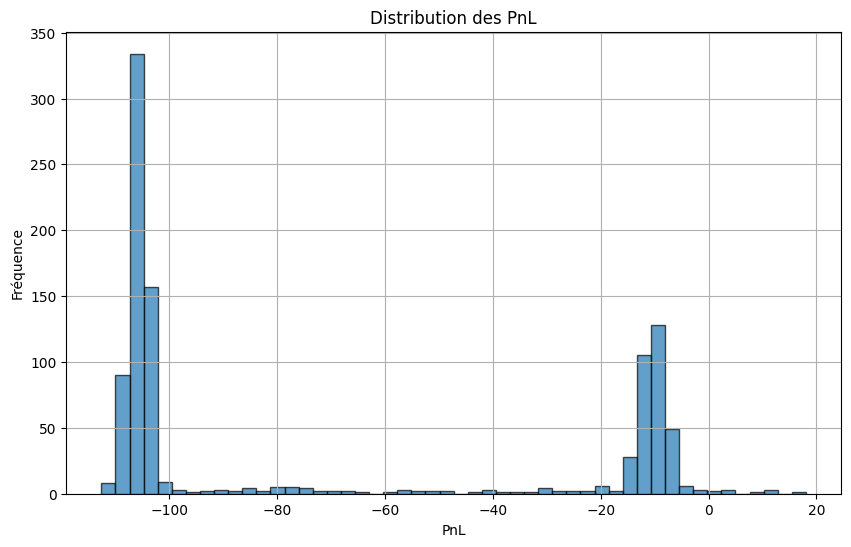

In [38]:
# Implémentation combinée de Delta-Hedging et Gamma-Hedging sous le modèle de Heston
def delta_gamma_hedging_heston(S0, K, r, T, steps, barrier, v0, kappa, theta, sigma_v, rho, n_paths=1000):
    S, v = heston_simulation(S0, v0, r, kappa, theta, sigma_v, rho, T, steps, n_paths)
    dt = T / steps
    final_pnl = []

    for i in range(n_paths):
        position_in_underlying = 0
        position_in_option = 0
        hedging_cost = 0
        crossed_barrier = False

        for t in range(steps):
            time_to_maturity = T - t * dt

            # Calculer Delta et Gamma
            sigma_t = np.sqrt(v[i, t])
            delta = calculate_delta(S[i, t], K, r, sigma_t, time_to_maturity)
            gamma = calculate_gamma(S[i, t], K, r, sigma_t, time_to_maturity)
            gamma_vanilla = calculate_gamma(S[i, t], K, r, sigma_t, time_to_maturity)

            # Calcul des ajustements Delta et Gamma
            delta_change = delta - position_in_underlying
            if abs(gamma_vanilla) > 1e-8:
                gamma_change = (gamma - position_in_option * gamma_vanilla) / gamma_vanilla
            else:
                gamma_change = 0

            # Calcul des coûts de couverture
            hedging_cost += delta_change * S[i, t]  # Coût d'ajustement Delta
            hedging_cost += gamma_change * S[i, t]  # Coût d'ajustement Gamma

            # Mise à jour des positions
            position_in_underlying = delta
            position_in_option += gamma_change

            if not crossed_barrier and S[i, t] > barrier:
                crossed_barrier = True

        # Calcul du payoff
        payoff = max(K - S[i, -1], 0) if crossed_barrier else 0
        pnl = payoff - hedging_cost
        final_pnl.append(pnl)

    return np.mean(final_pnl), np.std(final_pnl), final_pnl

# Simulation combinée Delta-Gamma-Hedging sous Heston
mean_pnl, std_pnl, pnl_list = delta_gamma_hedging_heston(
    S0, K, r, T, steps, barrier, v0, kappa, theta, sigma_v, rho, n_paths=1000
)

# Résultats
print(f"PnL moyen (Delta-Gamma-Hedging sous Heston): {mean_pnl:.4f}, Écart-type: {std_pnl:.4f}")

# Visualisation de la distribution des PnL
visualize_pnl_distribution(pnl_list)


PnL moyen : -70.7087
La stratégie entraîne des pertes significatives, montrant que les ajustements Gamma augmentent les coûts de couverture sans apporter suffisamment de bénéfices.
Écart-type : 45.0379
La variabilité est modérée, mais les pertes dominent, ce qui indique que la stratégie n'est pas optimale dans ce scénario.
2. Comparaison avec Delta-Hedging seul :
Delta-Hedging seul est clairement plus performant sous Heston :
Le PnL moyen est positif (
≈
31.46
≈31.46).
Les coûts de couverture restent maîtrisés.
La combinaison Delta-Gamma-Hedging introduit des ajustements supplémentaires qui augmentent les coûts sans réduire la variabilité ni améliorer les résultats.
3. Analyse des raisons des pertes :
Coûts élevés d'ajustement Gamma :

Le modèle de Heston, avec une volatilité stochastique, génère des variations de Gamma fréquentes.
Cela conduit à des ajustements coûteux, surtout si le sous-jacent évolue loin de la barrière.
Faible bénéfice de la couverture Gamma :

Dans ce scénario, les mouvements volatils autour de la barrière ne sont pas suffisamment fréquents pour justifier les ajustements Gamma.
